# Assignment - 2

In [135]:
import csv
import numpy as np
import collections
import threading
import matplotlib.pyplot as plt

## Data Extraction

In [136]:
# Extracting trading data from the file
with open('Iron_dealers_data.csv') as iron_dealers_file:
    csvreader = csv.reader(iron_dealers_file)
    next(csvreader)
    edges = {}
    nodes = set()
    for row in csvreader:
        seller = int(row[0])
        buyer = int(row[1])
        value = float(row[2])

        nodes.add(seller)
        nodes.add(buyer)

        # Calculating total transaction value between seller and buyer
        if edges.get((seller, buyer)) is None:
            edges[(seller, buyer)] = value
        else:
            edges[(seller, buyer)] += value

# Creating a file with Node ID's
with open('nodes.txt', 'w') as nodes_file:
        nodes_file.write('No. of nodes: {}\n'.format(len(nodes)))
        for node in nodes:
            nodes_file.write(str(node) + '\n')

# Creating a file with Edges and their total transaction value
with open('edges.txt', 'w') as edges_file:
        edges_file.write('No. of edges: {}\n'.format(len(edges)))
        for edge in edges:
            edges_file.write(str(edge[0]) + ',' + str(edge[1]) + ',' + str(edges[edge]) + '\n')

In [137]:
# Extracting the bad nodes
with open('bad.csv') as bad_file:
    csvreader = csv.reader(bad_file)
    next(csvreader)
    bad_nodes = set()
    for row in csvreader:
        bad_node = int(row[0])
        bad_nodes.add(bad_node)

# Creating a file with Node ID's of Bad nodes
with open('bad_nodes.txt', 'w') as bad_nodes_file:
    bad_nodes_file.write('No. of bad nodes: {}\n'.format(len(bad_nodes)))
    for bad_node in bad_nodes:
        bad_nodes_file.write(str(bad_node) + '\n')

## Pregel Class

In [138]:
"""pregel.py is a python 2.6 module implementing a toy single-machine
version of Google's Pregel system for large-scale graph processing."""
# Using the given Pregel Class 
class Vertex():

    def __init__(self,id,value,out_vertices):
        # This is mostly self-explanatory, but has a few quirks:
        #
        # self.id is included mainly because it's described in the
        # Pregel paper.  It is used briefly in the pagerank example,
        # but not in any essential way, and I was tempted to omit it.
        #
        # Each vertex stores the current superstep number in
        # self.superstep.  It's arguably not wise to store many copies
        # of global state in instance variables, but Pregel's
        # synchronous nature lets us get away with it.
        self.id = id 
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

   
class Pregel():

    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[self.worker(vertex)].append(vertex)
        return partition

    def worker(self,vertex):
        """Returns the id of the worker that vertex is assigned to."""
        return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep.  

        Note that in this implementation, worker threads are spawned,
        and then destroyed during each superstep.  This creation and
        destruction causes some overhead, and it would be better to
        make the workers persistent, and to use a locking mechanism to
        synchronize.  The Pregel paper suggests that this is how
        Google's Pregel implementation works."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            #print(f" Worker started with vertices list : {[v.id for v in vertex_list]}")
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertex,message) in vertex.outgoing_messages:
                receiving_vertex.incoming_messages.append((vertex,message))
            vertex.outgoing_messages = []

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()
        #time.sleep(10)
        #print(f" Worker completed superstep with vertices list : {[v.id for v in self.vertices]}")
        

    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()


## Trust Rank Class

In [139]:
""" Vertex class for TrustRank algorithm
    Can add instance varibles and methods according to algorithm
"""
class TrustRankVertex(Vertex):
    def __init__(self,id,value,out_vertices,dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        # Sum of weights of all outgoing edges
        self.sum_of_weights = 0.0

    def update(self):
        if self.superstep < self.num_supersteps:
            messages_sum = 0.0
            for (vertice ,message) in self.incoming_messages:
                messages_sum += message
            
            """ Updating the score of the node based on whether the node is a bad node or not """
            if self.id in bad_nodes:
                self.value = ((1-self.dampingFactor) / len(bad_nodes)) + (self.dampingFactor*messages_sum)
            else:
                self.value = self.dampingFactor*messages_sum

            """There will be not be any node with no outgoing edges as we assume that the score of these nodes is evenly distributed among bad nodes."""
            # Updating the outgoing bad score to be sent to the out vertices
            for vertex, weight in self.out_vertices:
                # Outgoing bad score calculated based on the weight of the edge connecting out vertices
                outgoing_message = self.value * (weight / self.sum_of_weights)
                self.outgoing_messages.append((vertex, outgoing_message))
        else:
            self.active = False

## Function to get outgoing vertices for each vertex

In [140]:
""" Updating out going vertices for each vertex using edges """
def updateOutGoingVertices(vertices, id_vertex_map):
    for edge in edges:
        frm,to = edge
        weight = edges[edge]
        frm_vertex = id_vertex_map.get(frm)
        to_vertex = id_vertex_map.get(to)

        frm_vertex.out_vertices.append((to_vertex, weight))
        frm_vertex.sum_of_weights += weight

    """If there are vertices with no outgoing edges, then we evenly distribute the score of these nodes among bad nodes. Hence we set the out vertices of these nodes to be bad nodes."""""
    for vertex in vertices:
        if len(vertex.out_vertices) == 0:
            for bad_node in bad_nodes:
                bad_vertex = id_vertex_map.get(bad_node)
                vertex.out_vertices.append((bad_vertex, 1.0))
            vertex.sum_of_weights = len(bad_nodes)


## Function to run the trust rank algorithm using Pregel

In [141]:
# Pregel implementation for TrustRank
def pregelTrustRank(vertices, num_workers):
    p = Pregel(vertices,num_workers)
    p.run()
    return np.array([(vertex.id, vertex.value) for vertex in p.vertices])

## Function to compute Initial Bad Score

In [142]:
"""We give the bad nodes a score of 1/number of bad nodes and the rest of the nodes a score of 0"""
def ComputeInitialBadScore():
    vertices = []

    # We create a map of id to vertex for easy access when we have id
    """This is to bring down the time complexity from O(n^2) to O(n)"""
    id_vertex_map = {}

    initial_bad_score = 1/len(bad_nodes)

    for node in nodes:
        if node in bad_nodes:
            vertex = TrustRankVertex(node, initial_bad_score, [], iterations=100)
        else:
            vertex = TrustRankVertex(node, 0.0, [], iterations=100)
        vertices.append(vertex)
        id_vertex_map[node] = vertex

    return vertices, id_vertex_map

## Run on the given data

In [143]:
num_workers = 4

vertices, id_vertex_map = ComputeInitialBadScore()
updateOutGoingVertices(vertices, id_vertex_map)

In [144]:
bad_score_vector = pregelTrustRank(vertices, num_workers)

# Sorting the bad score vector based on the id of the node
idx = np.argsort(bad_score_vector[:, 0])
sortidx_bad_score_vector = bad_score_vector[idx]

In [145]:
# Writing the bad score vector to a csv file for easy access 
with open('bad_scores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Node ID', 'Bad Score'])
    writer.writerows(sortidx_bad_score_vector)

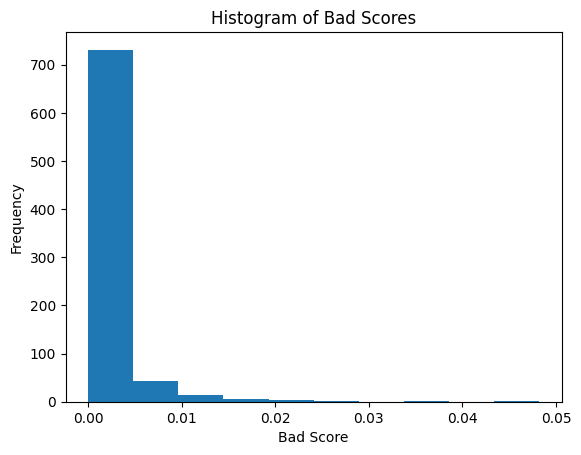

In [146]:
# Histogram showing the distribution of bad scores
plt.hist(sortidx_bad_score_vector[:,1])
plt.xlabel('Bad Score')
plt.ylabel('Frequency')
plt.title('Histogram of Bad Scores')
plt.show()

In [147]:
# sorting the bad score vector based on the bad score of the node
idx = np.argsort(bad_score_vector[:, 1])
sortRank_bad_score_vector = bad_score_vector[idx]

print("Top 20 bad nodes : ")
print("Node ID, Bad Score")
for vec in sortRank_bad_score_vector[-1:-21:-1]:
    print(str(int(vec[0])) + ' :  ' + str(vec[1]))

Top 20 bad nodes : 
Node ID, Bad Score
1088 :  0.048187301344225095
1144 :  0.046434468425409776
1007 :  0.03765229959281566
1210 :  0.024525230899676592
1034 :  0.02319570756200716
1039 :  0.02001732027224442
1011 :  0.0194336881419667
1042 :  0.01923032462707741
1086 :  0.017891003340082947
1076 :  0.017850033951805424
1309 :  0.01685717387233079
1094 :  0.015183681965865269
1147 :  0.014666973467489451
1173 :  0.014283015404572849
1099 :  0.013732203701953029
1201 :  0.013541780851813132
1122 :  0.01322098284042478
1079 :  0.012788815817270302
1138 :  0.012649093696215304
1041 :  0.012140561388011041


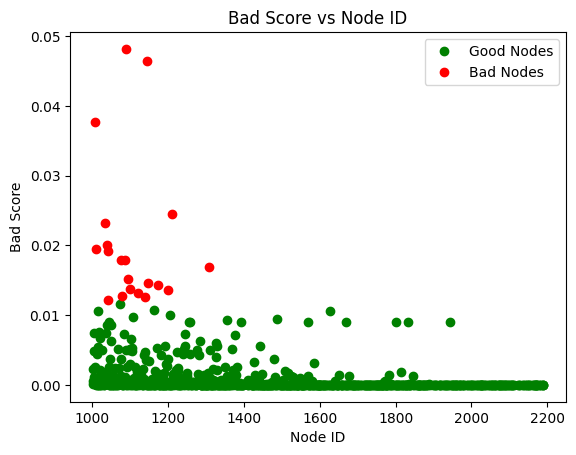

In [153]:
# Plot to give idea on how the bad score is distributed among the nodes by taking top 20 nodes with highest bad score as bad nodes
plt.plot(sortRank_bad_score_vector[:-20,0], sortRank_bad_score_vector[:-20,1], 'go', label='Good Nodes')
plt.plot(sortRank_bad_score_vector[-20:,0], sortRank_bad_score_vector[-20:,1], 'ro', label='Bad Nodes')
plt.xlabel('Node ID')
plt.ylabel('Bad Score')
plt.title('Bad Score vs Node ID')
plt.legend()
plt.show()